In [1]:
import numpy as np
import pandas as pd
import datetime

from itertools import combinations
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score, confusion_matrix, f1_score
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')
np.random.seed(4590)

pd.options.display.precision = 7
pd.options.display.max_rows = 50
pd.options.display.max_columns = 300

/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew in

In [2]:
df_train = pd.read_csv('../input/20181216_train.csv')
df_test = pd.read_csv('../input/20181216_test.csv')

In [3]:
df_train["card_num"] = df_train.card_id.apply(lambda x:int(x.replace("C_ID_", ""), 16)/10000000000.0)
df_test["card_num"] = df_test.card_id.apply(lambda x:int(x.replace("C_ID_", ""), 16)/10000000000.0)

In [4]:
def merge_new_feature(path):
    df_new_feature = pd.read_csv(path)
    
    df_tr = pd.merge(df_train, df_new_feature, on="card_id", how="left")
    df_te = pd.merge(df_test, df_new_feature, on="card_id", how="left")
    
    return df_tr, df_te

In [5]:
df_train, df_test = merge_new_feature("../input/feature_categorical_count_rate.csv")
# df_train, df_test = merge_new_feature("../input/feature_categorical_rete__by__categorical_count.csv")
df_train, df_test = merge_new_feature("../input/feature_various_time_data.csv")
df_train, df_test = merge_new_feature("../input/merchants_nmf.csv")
df_train, df_test = merge_new_feature("../input/city_nmf.csv")
df_train, df_test = merge_new_feature("../input/state_nmf.csv")
df_train, df_test = merge_new_feature("../input/merchants_category3_A_nmf.csv")
df_train, df_test = merge_new_feature("../input/feature_catogorical_count_weighted_elapsed.csv")
df_train, df_test = merge_new_feature("../input/feature_latest_transaction_data__per__card_id.csv")
df_train, df_test = merge_new_feature("../input/feature_term_from_second_latest_to_latest.csv")
df_train, df_test = merge_new_feature("../input/feature_nunique_marchant__per__card_id.csv")
df_train, df_test = merge_new_feature("../input/feature_purchase_amount_mean_max_increase.csv")
df_train, df_test = merge_new_feature("../input/feature_frequency_mean_increase_rate.csv")
df_train, df_test = merge_new_feature("../input/feature_card_count_increase_rate.csv")
df_train, df_test = merge_new_feature("../input/feature_new_merchant_trs_card_flag.csv")
df_train, df_test = merge_new_feature("../input/feature_count_null_in_h_trs.csv")
df_train, df_test = merge_new_feature("../input/feature_card_valid_term.csv")
df_train, df_test = merge_new_feature("../input/feature_most_used_city_id.csv")
df_train, df_test = merge_new_feature("../input/feature_most_used_state_id.csv")
df_train, df_test = merge_new_feature("../input/feature_purchased_merchant_from_city_num_count_rate.csv")
df_train, df_test = merge_new_feature("../input/feature_purchase_num__per__purchase_month_count_rate.csv")
df_train, df_test = merge_new_feature("../input/feature_purchase_sig_amount__per__purchase_month_sum_rate.csv")

In [6]:
agg_func = {
    "target": ["median"]
}
df_feature_most_used_city_agg = df_train.groupby("most_used_city_id").agg(agg_func).reset_index()
df_feature_most_used_city_agg.columns = ["most_used_city_id", "most_used_city_target_mean"]

df_train = pd.merge(df_train, df_feature_most_used_city_agg, on="most_used_city_id", how="left")
df_test =  pd.merge(df_test, df_feature_most_used_city_agg, on="most_used_city_id", how="left")

In [7]:
for i in range(1,21):
    col = "NMF_category3_comp_{}".format(i)
    df_train[col] = df_train[col].fillna(0)
    df_test[col] = df_test[col].fillna(0)

In [8]:
# high_imp = [
#     'elapsed_from_latest_purchase_date',
#     'count_increase_rate_from_all_to_latest6',
#     'authorized_flag_ture_rate',
#     'purchase_amount_latest_trs',
#     'month_lag_2_rate',
#     'frequency_increase_rate_from_all_to_latest6',
#     'category_1_true',
#     'NMF_comp_3',
#     'increase_rate_from_all_to_latest3',
#     'NMF_comp_12'
# ]

# comb = list(itertools.combinations(high_imp, 2))

# for df in [df_train, df_test]:
#     for i,j in comb:
#         new_col_name = "{c1}__div__{c2}".format(c1=i, c2=j)
#         values1 = df[i].apply(lambda x:x if x>0 else 0.001)
#         values2 = df[j].apply(lambda x:x if x>0 else 0.001)
#         df[new_col_name] = values1 / values2

In [9]:
dont_use = ['card_id', 'first_active_month','target', 'feature', 'outliers', 'most_used_city_id']

df_train_columns = [c for c in df_train.columns if c not in dont_use]
target = df_train['target']
target_outliers = df_train['outliers']

In [10]:
drop_col = []
comb = list(combinations(df_train_columns, 2))

for c1, c2 in comb:
    corr = np.corrcoef(df_train[c1], df_train[c2])[0,1]
    if corr >= 0.95:
        print("【{i}】 --- 【{j}】".format(i=c1, j=c2))
        print(corr)
        drop_col.append(c2)
        print("\n"*2)

【hist_merchant_id_nunique】 --- 【nunique_merchant】
0.9848861821888529



【hist_month_diff_mean】 --- 【hist_purchase_date_uptonow】
0.9574464931933617



【hist_authorized_flag_sum】 --- 【hist_card_id_size】
0.9945716227736431



【hist_authorized_flag_sum】 --- 【card_id_count】
0.9935317230513652



【hist_authorized_flag_sum】 --- 【authorized_flag_ture】
0.9979558326172671



【hist_authorized_flag_sum】 --- 【authorized_flag_ture_weighted_elapsed】
0.9979558326172671



【hist_authorized_flag_mean】 --- 【authorized_flag_ture_rate】
0.9871399739794636



【hist_category_1_sum】 --- 【category_1_true】
0.9996032083806138



【hist_category_1_sum】 --- 【category_1_true_weighted_elapsed】
0.9996032083806138



【hist_category_1_mean】 --- 【category_1_true_rate】
0.9915584786977886



【hist_card_id_size】 --- 【card_id_count】
0.9981205383400666



【hist_card_id_size】 --- 【authorized_flag_ture】
0.991907744189161



【hist_card_id_size】 --- 【authorized_flag_ture_weighted_elapsed】
0.991907744189161



【hist_purchase_date_d

In [11]:
sorted(set(drop_col))

['NMF_category3_comp_15',
 'NMF_category3_comp_5',
 'authorized_flag_ture',
 'authorized_flag_ture_rate',
 'authorized_flag_ture_weighted_elapsed',
 'card_id_count',
 'card_valid_term',
 'category_1_true',
 'category_1_true_rate',
 'category_1_true_weighted_elapsed',
 'category_3_A_latest_trs',
 'count_null_category_2',
 'count_null_category_3',
 'count_purchase_num_in_Jan_2018',
 'elapsed_from_oldest_purchase_date_to_first_active',
 'elapsed_from_oldest_purchase_date_to_latest_purchase_date',
 'frequency_all',
 'hist_card_id_size',
 'hist_purchase_date_uptonow',
 'installments_0',
 'installments_0_rate',
 'installments_0_weighted_elapsed',
 'installments_1',
 'installments_1_rate',
 'installments_1_weighted_elapsed',
 'month_lag_N10_weighted_elapsed',
 'month_lag_N11_weighted_elapsed',
 'month_lag_N12_weighted_elapsed',
 'month_lag_N13_weighted_elapsed',
 'month_lag_N6_weighted_elapsed',
 'month_lag_N7_weighted_elapsed',
 'month_lag_N8_weighted_elapsed',
 'month_lag_N9_weighted_elapse

In [12]:
for col in df_train_columns:
    if col in sorted(set(drop_col)):
        df_train_columns.remove(col)

In [13]:
len(df_train_columns)

423

In [14]:
# categorical = [
#     "feature_1",
#     "feature_2",
#     "feature_3",
#     "most_used_state_id"
# ]

In [15]:
df_train[df_train_columns].head()

,feature_1,feature_2,feature_3,hist_month_nunique,hist_hour_nunique,hist_weekofyear_nunique,hist_dayofweek_nunique,hist_year_nunique,hist_subsector_id_nunique,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_mean,hist_purchase_amount_var,hist_installments_sum,hist_installments_max,hist_installments_min,hist_installments_mean,hist_installments_var,hist_purchase_date_max,hist_purchase_date_min,hist_month_lag_max,hist_month_lag_min,hist_month_lag_mean,hist_month_lag_var,hist_month_diff_mean,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_weekend_sum,hist_weekend_mean,hist_category_1_sum,hist_category_1_mean,hist_category_2_mean_mean,hist_category_3_mean_mean,hist_purchase_date_diff,hist_purchase_date_average,new_hist_month_nunique,new_hist_hour_nunique,new_hist_weekofyear_nunique,new_hist_dayofweek_nunique,new_hist_year_nunique,new_hist_subsector_id_nunique,new_hist_merchant_id_nunique,new_hist_merchant_category_id_nunique,new_hist_purchase_amount_sum,new_hist_purchase_amount_max,new_hist_purchase_amount_min,new_hist_purchase_amount_mean,new_hist_purchase_amount_var,new_hist_installments_sum,new_hist_installments_max,new_hist_installments_min,new_hist_installments_mean,new_hist_installments_var,new_hist_purchase_date_max,new_hist_month_lag_max,new_hist_month_lag_min,new_hist_month_lag_mean,new_hist_month_lag_var,new_hist_month_diff_mean,new_hist_weekend_sum,new_hist_weekend_mean,new_hist_category_1_sum,new_hist_category_1_mean,new_hist_card_id_size,new_hist_category_2_mean_mean,new_hist_category_3_mean_mean,new_hist_purchase_date_diff,new_hist_purchase_date_average,new_hist_purchase_date_uptonow,dayofweek,weekofyear,month,elapsed_time,hist_first_buy,new_hist_first_buy,card_id_total,purchase_amount_total,hist_month_diff_mean__div__hist_authorized_flag_mean,hist_month_diff_mean__div__hist_category_1_sum,hist_month_diff_mean__div__hist_month_lag_mean,hist_month_diff_mean__div__new_hist_purchase_amount_sum,hist_month_diff_mean__div__new_hist_purchase_date_uptonow,hist_authorized_flag_mean__div__hist_category_1_sum,hist_authorized_flag_mean__div__hist_month_lag_mean,hist_authorized_flag_mean__div__new_hist_purchase_amount_sum,hist_authorized_flag_mean__div__new_hist_purchase_date_uptonow,hist_category_1_sum__div__hist_month_lag_mean,hist_category_1_sum__div__new_hist_purchase_amount_sum,hist_category_1_sum__div__new_hist_purchase_date_uptonow,hist_month_lag_mean__div__new_hist_purchase_amount_sum,hist_month_lag_mean__div__new_hist_purchase_date_uptonow,new_hist_purchase_amount_sum__div__new_hist_purchase_date_uptonow,card_num,authorized_flag_ture,category_1_true,category_2_1,category_2_2,category_2_3,category_2_4,category_2_5,category_2_1_rate,category_2_2_rate,category_2_3_rate,category_2_4_rate,category_2_5_rate,category_3_A,category_3_B,category_3_C,category_3_A_rate,category_3_B_rate,category_3_C_rate,category_4_true,category_4_true_rate,installments_N,installments_1,installments_2,installments_3,installments_4,installments_5,installments_6,installments_7_,installments_N_rate,installments_1_rate,installments_2_rate,installments_3_rate,installments_4_rate,installments_5_rate,installments_6_rate,installments_7__rate,month_lag_N13,month_lag_N12,month_lag_N11,month_lag_N10,month_lag_N9,month_lag_N8,month_lag_N7,month_lag_N6,month_lag_N5,month_lag_N4,month_lag_N3,month_lag_N2,month_lag_N1,month_lag_0,month_lag_1,month_lag_2,month_lag_N13_rate,month_lag_N12_rate,...,NMF_category3_comp_9,NMF_category3_comp_10,NMF_category3_comp_11,NMF_category3_comp_12,NMF_category3_comp_13,NMF_category3_comp_14,NMF_category3_comp_16,NMF_category3_comp_17,NMF_category3_comp_18,NMF_category3_comp_19,NMF_category3_comp_20,category_1_true_weighted_elapsed,category_2_1_weighted_elapsed,category_2_2_weighted_elapsed,category_2_3_weighted_elapsed,category_2_4_weighted_elapsed,category_2_5_weighted_elapsed,category_3_A_weighted_elapsed,category_3_B_

In [16]:
df_train.shape

(201917, 474)

In [18]:
#original
param = {
    'num_leaves': 31,  # 31
    'min_data_in_leaf': 30,
    'objective':'regression',
    'max_depth': -1,  # -1
    'learning_rate': 0.004,
    "min_child_samples": 20,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9 ,
    "bagging_seed": 11,
    "metric": 'rmse',
    "lambda_l1": 0.1,
    "verbosity": -1,
    "nthread": 4,
    "random_state": 1000 #4590
}

# param = {
#     'num_leaves': 31,  # 31
#     'min_data_in_leaf': 30,
#     'objective':'binary',
#     'max_depth': 6,  # -1
#     'learning_rate': 0.004,
#     "min_child_samples": 20,
#     "boosting": "gbdt",
#     "feature_fraction": 0.9,
#     "bagging_freq": 1,
#     "bagging_fraction": 0.9 ,
#     "bagging_seed": 11,
#     "metric": 'auc',
#     "lambda_l1": 0.1,
#     "verbosity": -1,
#     "nthread": 4,
#     "random_state": 1000 #4590
# }


folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1000) #4590
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 400)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(target, oof))
# roc_auc_score(target, oof)

fold 0
Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 3.73713	valid_1's rmse: 3.77437
[200]	training's rmse: 3.66666	valid_1's rmse: 3.73166
[300]	training's rmse: 3.61693	valid_1's rmse: 3.70826
[400]	training's rmse: 3.57899	valid_1's rmse: 3.69347
[500]	training's rmse: 3.549	valid_1's rmse: 3.68294
[600]	training's rmse: 3.52401	valid_1's rmse: 3.67565
[700]	training's rmse: 3.50264	valid_1's rmse: 3.66993
[800]	training's rmse: 3.48349	valid_1's rmse: 3.66522
[900]	training's rmse: 3.46633	valid_1's rmse: 3.66169
[1000]	training's rmse: 3.45056	valid_1's rmse: 3.65867
[1100]	training's rmse: 3.43562	valid_1's rmse: 3.65609
[1200]	training's rmse: 3.42173	valid_1's rmse: 3.654
[1300]	training's rmse: 3.40858	valid_1's rmse: 3.65257
[1400]	training's rmse: 3.3954	valid_1's rmse: 3.65109
[1500]	training's rmse: 3.38317	valid_1's rmse: 3.64986
[1600]	training's rmse: 3.37128	valid_1's rmse: 3.64873
[1700]	training's rmse: 3.35978	valid_1's rmse: 

[2500]	training's rmse: 3.2736	valid_1's rmse: 3.66589
[2600]	training's rmse: 3.26457	valid_1's rmse: 3.66568
[2700]	training's rmse: 3.25605	valid_1's rmse: 3.66578
[2800]	training's rmse: 3.24768	valid_1's rmse: 3.66537
[2900]	training's rmse: 3.23968	valid_1's rmse: 3.66541
[3000]	training's rmse: 3.23185	valid_1's rmse: 3.66534
[3100]	training's rmse: 3.22334	valid_1's rmse: 3.66498
[3200]	training's rmse: 3.2156	valid_1's rmse: 3.665
[3300]	training's rmse: 3.20797	valid_1's rmse: 3.66501
[3400]	training's rmse: 3.20037	valid_1's rmse: 3.66502
[3500]	training's rmse: 3.19288	valid_1's rmse: 3.66485
[3600]	training's rmse: 3.18576	valid_1's rmse: 3.66477
[3700]	training's rmse: 3.17858	valid_1's rmse: 3.66442
[3800]	training's rmse: 3.17123	valid_1's rmse: 3.6644
[3900]	training's rmse: 3.16409	valid_1's rmse: 3.66416
[4000]	training's rmse: 3.15725	valid_1's rmse: 3.66412
[4100]	training's rmse: 3.15026	valid_1's rmse: 3.66411
[4200]	training's rmse: 3.14327	valid_1's rmse: 3.664

3.64420411520109

In [19]:
# 3.643709827383528

In [20]:
# confusion_matrix(target_outliers, np.where(oof>=0.7, 1, 0))

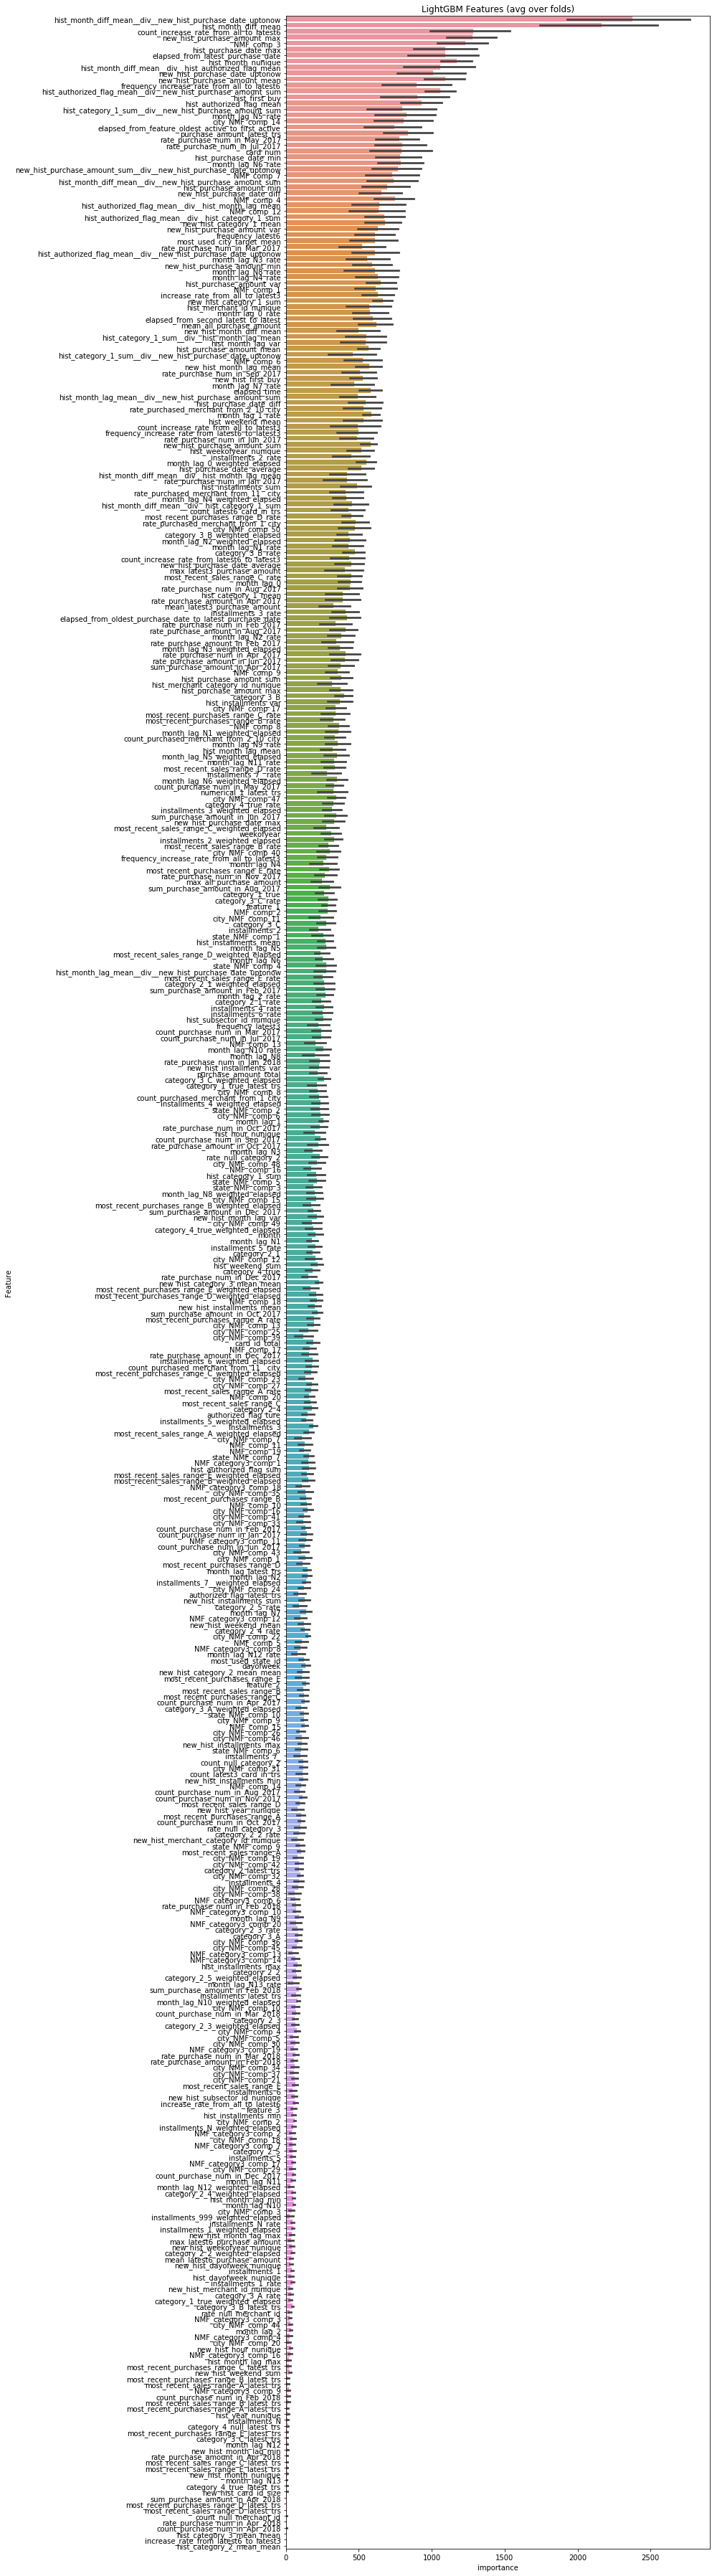

In [21]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

--- 

In [22]:
high_imp_features = cols[:200].tolist()

In [23]:
#original
param = {
    'num_leaves': 31,  # 31
    'min_data_in_leaf': 30,
    'objective':'regression',
    'max_depth': -1,  # -1
    'learning_rate': 0.004,
    "min_child_samples": 20,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9 ,
    "bagging_seed": 11,
    "metric": 'rmse',
    "lambda_l1": 0.1,
    "verbosity": -1,
    "nthread": 4,
    "random_state": 1000 #4590
}


folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1000) #4590
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][high_imp_features], label=target.iloc[trn_idx])#, categorical_feature=categorical)
    val_data = lgb.Dataset(df_train.iloc[val_idx][high_imp_features], label=target.iloc[val_idx])#, categorical_feature=categorical)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 400)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][high_imp_features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = high_imp_features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[high_imp_features], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(target, oof))

fold 0
Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 3.73779	valid_1's rmse: 3.77488
[200]	training's rmse: 3.66765	valid_1's rmse: 3.73212
[300]	training's rmse: 3.6186	valid_1's rmse: 3.70809
[400]	training's rmse: 3.58082	valid_1's rmse: 3.69335
[500]	training's rmse: 3.55141	valid_1's rmse: 3.68277
[600]	training's rmse: 3.5267	valid_1's rmse: 3.67528
[700]	training's rmse: 3.50583	valid_1's rmse: 3.6701
[800]	training's rmse: 3.48687	valid_1's rmse: 3.66537
[900]	training's rmse: 3.46986	valid_1's rmse: 3.66161
[1000]	training's rmse: 3.45409	valid_1's rmse: 3.65847
[1100]	training's rmse: 3.43908	valid_1's rmse: 3.65614
[1200]	training's rmse: 3.42535	valid_1's rmse: 3.65425
[1300]	training's rmse: 3.41248	valid_1's rmse: 3.65246
[1400]	training's rmse: 3.39887	valid_1's rmse: 3.65092
[1500]	training's rmse: 3.38665	valid_1's rmse: 3.64951
[1600]	training's rmse: 3.37471	valid_1's rmse: 3.64833
[1700]	training's rmse: 3.3634	valid_1's rmse:

[2100]	training's rmse: 3.31487	valid_1's rmse: 3.66276
[2200]	training's rmse: 3.30507	valid_1's rmse: 3.66247
[2300]	training's rmse: 3.29586	valid_1's rmse: 3.66206
[2400]	training's rmse: 3.28622	valid_1's rmse: 3.66174
[2500]	training's rmse: 3.27717	valid_1's rmse: 3.66154
[2600]	training's rmse: 3.26801	valid_1's rmse: 3.6613
[2700]	training's rmse: 3.25905	valid_1's rmse: 3.66145
[2800]	training's rmse: 3.25046	valid_1's rmse: 3.66132
[2900]	training's rmse: 3.24235	valid_1's rmse: 3.66114
[3000]	training's rmse: 3.23431	valid_1's rmse: 3.66086
[3100]	training's rmse: 3.22602	valid_1's rmse: 3.66081
[3200]	training's rmse: 3.21841	valid_1's rmse: 3.66078
[3300]	training's rmse: 3.21101	valid_1's rmse: 3.66074
[3400]	training's rmse: 3.2034	valid_1's rmse: 3.66048
[3500]	training's rmse: 3.19586	valid_1's rmse: 3.65999
[3600]	training's rmse: 3.18869	valid_1's rmse: 3.66002
[3700]	training's rmse: 3.18116	valid_1's rmse: 3.6599
[3800]	training's rmse: 3.17366	valid_1's rmse: 3.6

3.6420619577835147

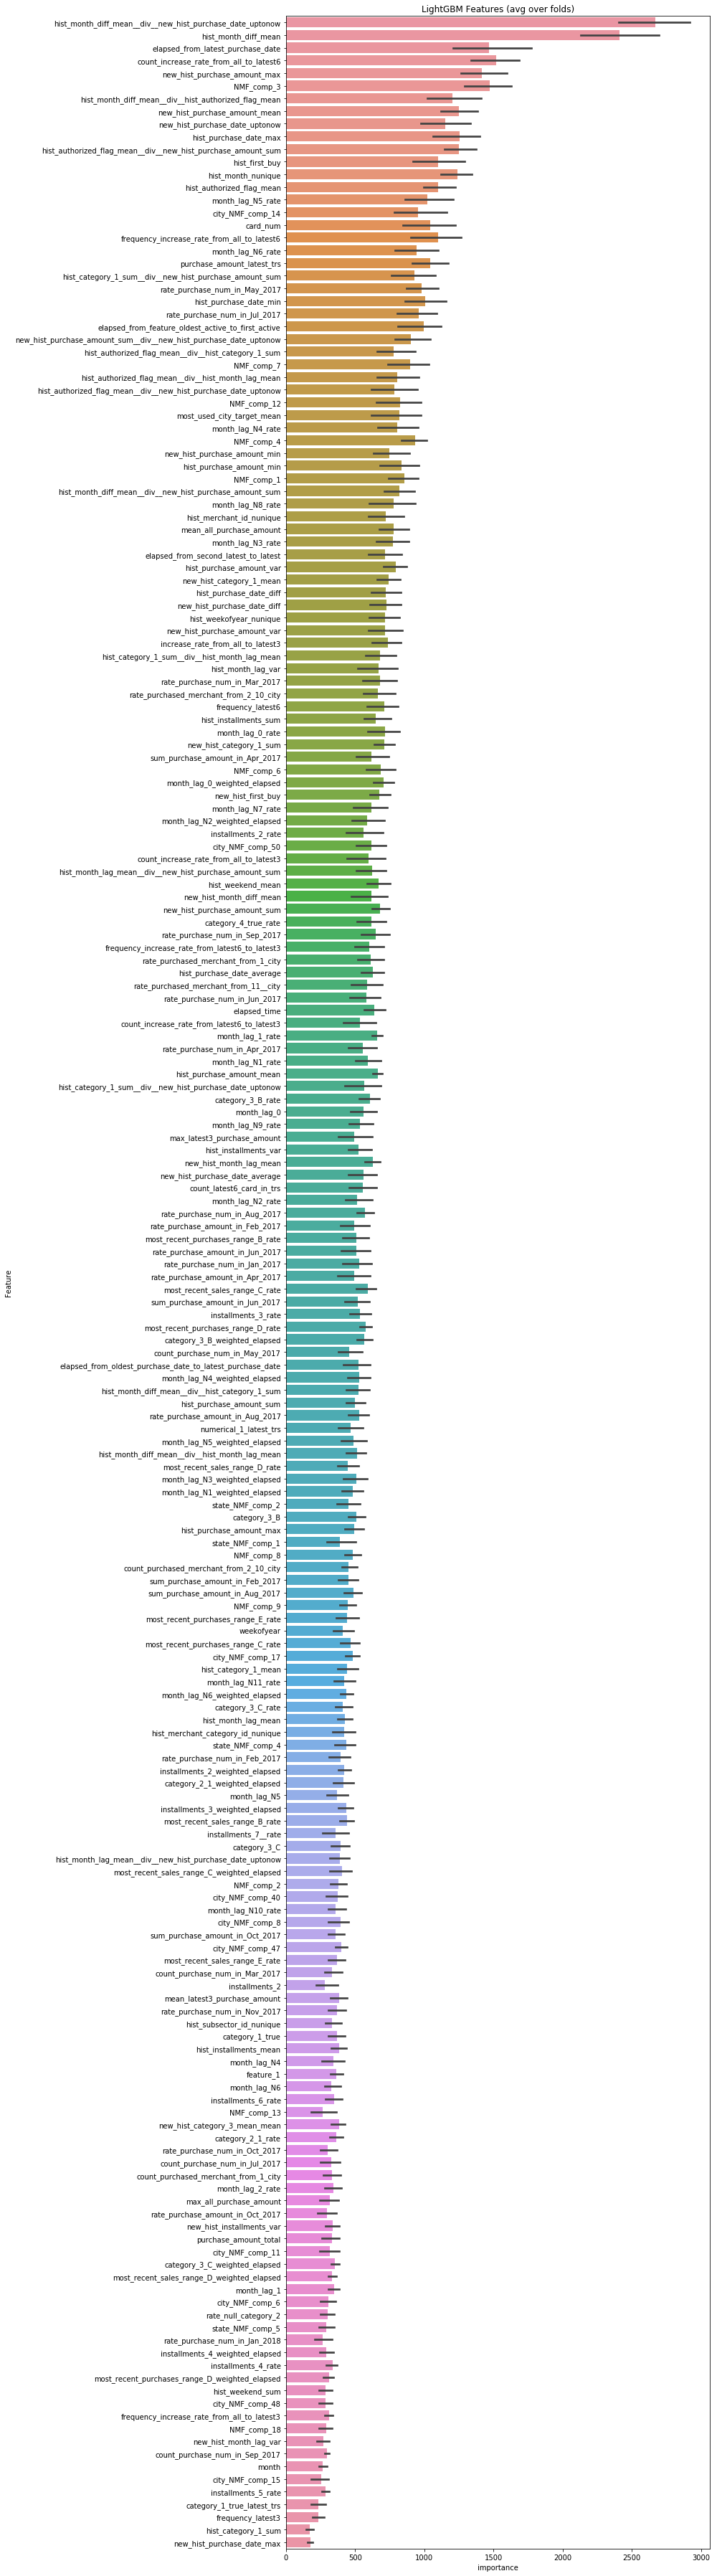

In [24]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

 ---

In [25]:
high_imp_features2 = cols[:150].tolist()

In [26]:
#original
param = {
    'num_leaves': 31,  # 31
    'min_data_in_leaf': 30,
    'objective':'regression',
    'max_depth': -1,  # -1
    'learning_rate': 0.004,
    "min_child_samples": 20,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9 ,
    "bagging_seed": 11,
    "metric": 'rmse',
    "lambda_l1": 0.1,
    "verbosity": -1,
    "nthread": 4,
    "random_state": 4590
}

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1000) #4590
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][high_imp_features2], label=target.iloc[trn_idx])#, categorical_feature=categorical)
    val_data = lgb.Dataset(df_train.iloc[val_idx][high_imp_features2], label=target.iloc[val_idx])#, categorical_feature=categorical)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 400)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][high_imp_features2], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = high_imp_features2
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[high_imp_features2], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(target, oof))
# roc_auc_score(target, oof)

fold 0
Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 3.73803	valid_1's rmse: 3.77409
[200]	training's rmse: 3.66876	valid_1's rmse: 3.73178
[300]	training's rmse: 3.62004	valid_1's rmse: 3.70735
[400]	training's rmse: 3.58337	valid_1's rmse: 3.69326
[500]	training's rmse: 3.55437	valid_1's rmse: 3.68329
[600]	training's rmse: 3.52926	valid_1's rmse: 3.6757
[700]	training's rmse: 3.50861	valid_1's rmse: 3.6709
[800]	training's rmse: 3.49013	valid_1's rmse: 3.66627
[900]	training's rmse: 3.47346	valid_1's rmse: 3.66319
[1000]	training's rmse: 3.45758	valid_1's rmse: 3.66039
[1100]	training's rmse: 3.44335	valid_1's rmse: 3.65817
[1200]	training's rmse: 3.4298	valid_1's rmse: 3.65628
[1300]	training's rmse: 3.41684	valid_1's rmse: 3.65477
[1400]	training's rmse: 3.40421	valid_1's rmse: 3.6535
[1500]	training's rmse: 3.39227	valid_1's rmse: 3.65236
[1600]	training's rmse: 3.3805	valid_1's rmse: 3.65127
[1700]	training's rmse: 3.36959	valid_1's rmse: 

[3500]	training's rmse: 3.20088	valid_1's rmse: 3.66427
[3600]	training's rmse: 3.19369	valid_1's rmse: 3.66414
[3700]	training's rmse: 3.18648	valid_1's rmse: 3.66406
[3800]	training's rmse: 3.17893	valid_1's rmse: 3.66396
[3900]	training's rmse: 3.1719	valid_1's rmse: 3.66395
[4000]	training's rmse: 3.16473	valid_1's rmse: 3.66393
[4100]	training's rmse: 3.15774	valid_1's rmse: 3.66383
[4200]	training's rmse: 3.15075	valid_1's rmse: 3.66372
[4300]	training's rmse: 3.14385	valid_1's rmse: 3.66349
[4400]	training's rmse: 3.13749	valid_1's rmse: 3.66353
[4500]	training's rmse: 3.13068	valid_1's rmse: 3.66344
[4600]	training's rmse: 3.12436	valid_1's rmse: 3.66333
[4700]	training's rmse: 3.118	valid_1's rmse: 3.66338
[4800]	training's rmse: 3.11149	valid_1's rmse: 3.66353
[4900]	training's rmse: 3.10489	valid_1's rmse: 3.66347
Early stopping, best iteration is:
[4558]	training's rmse: 3.12708	valid_1's rmse: 3.66326
fold 4
Training until validation scores don't improve for 400 rounds.
[1

3.6434281936472295

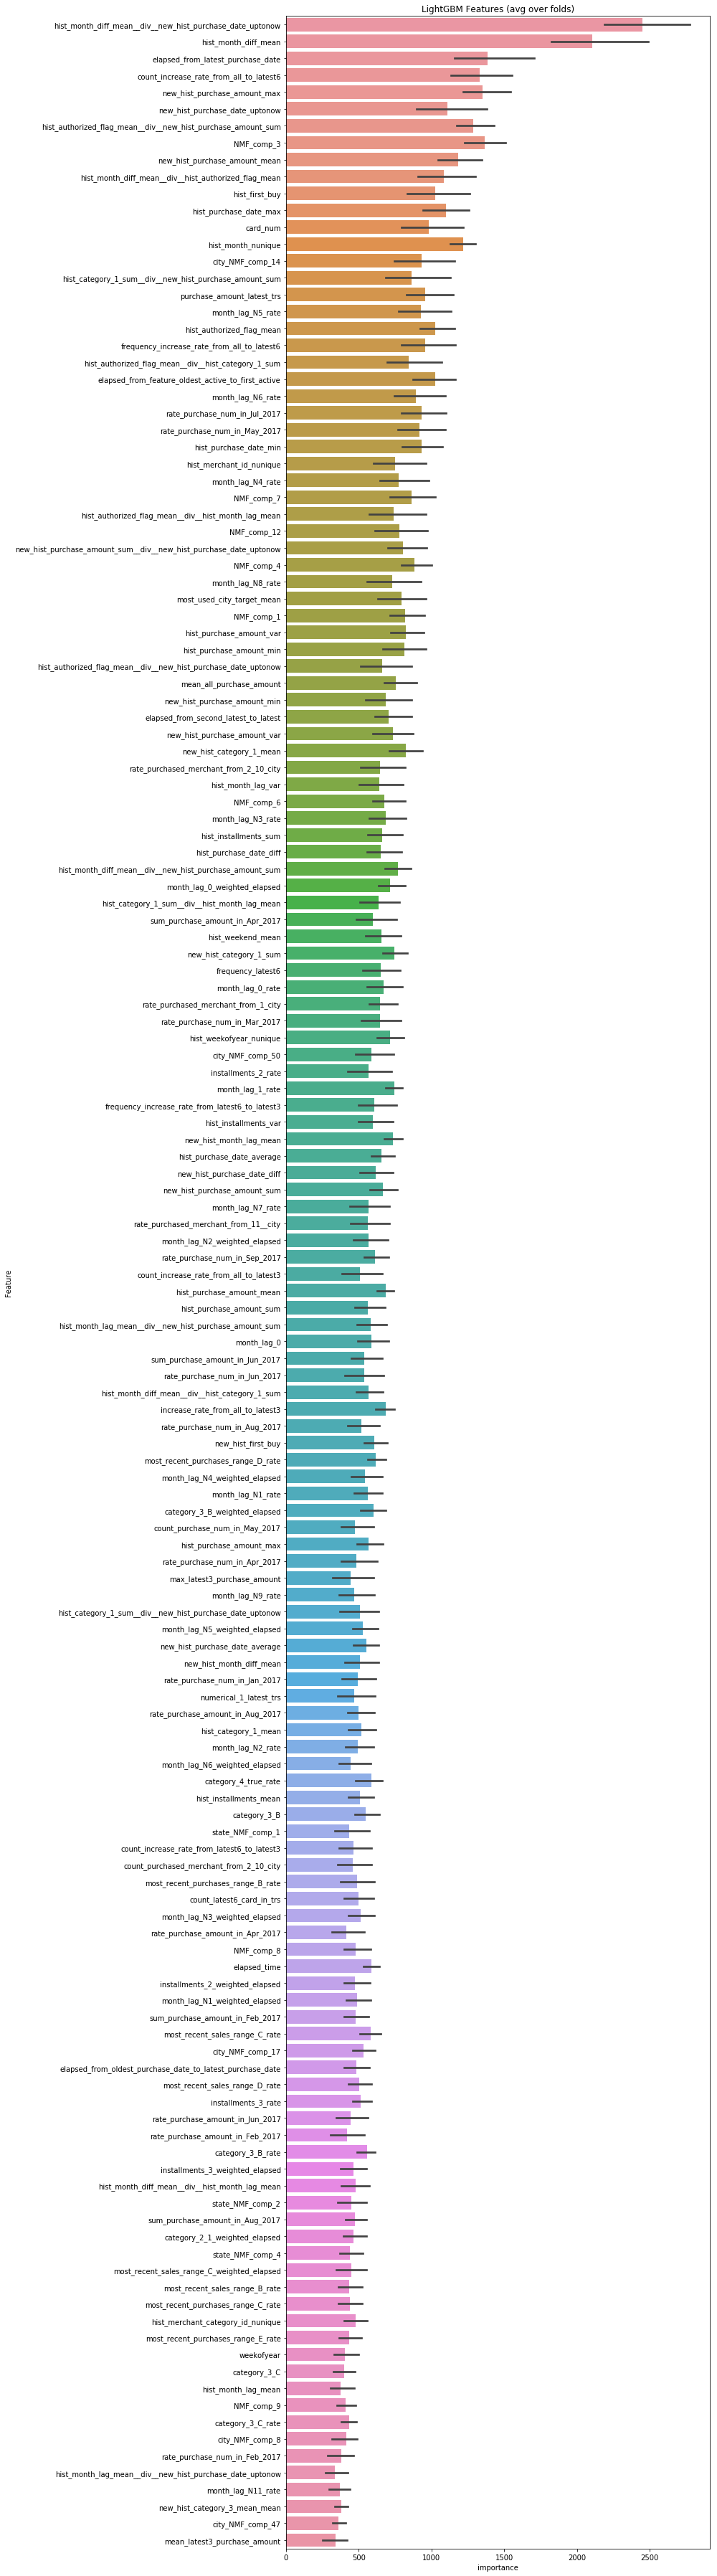

In [27]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [367]:
submission = pd.DataFrame({"card_id":df_test.card_id, "target":predictions})

In [368]:
submission

,card_id,target
0,C_ID_0ab67a22ab,-2.3322649
1,C_ID_130fd0cbdd,-0.3520062
2,C_ID_b709037bc5,-1.2062852
3,C_ID_d27d835a9f,-0.0014703
4,C_ID_2b5e3df5c2,-1.3321733
5,C_ID_5814b4f13c,0.0354465
6,C_ID_a1b3c75277,0.1513597
7,C_ID_f7cada36d3,0.7537312
8,C_ID_9d2bc8dfc4,-0.5277846
9,C_ID_6d8dba8475,-1.0653841


In [369]:
submission.to_csv("../output/submission_model20190102.csv", index=False)

In [2]:
sub1 = pd.read_csv("../output/submission_model20181216.csv")
sub2 = pd.read_csv("../output/submission_model20190102.csv")

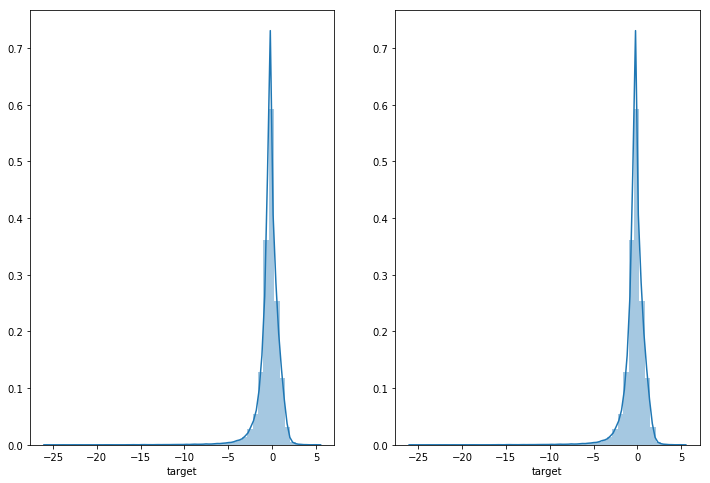

In [11]:
plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
sns.distplot(sub1.target)
plt.subplot(1, 2, 2)
sns.distplot(sub1.target)